# Joining Proteomic to Genetic Data

For some tasks, like pQTL analysis, we may be interested in jointly analyzing variant dosage and corresponding protein isoform abundance. This notebook demonstrates briefly how you may query a Bystro dataset and join it to protein abundance data for analysis

In [2]:
import re

import pandas as pd

from bystro.api import auth
from bystro.proteomics.annotation_interface import (
    get_annotation_result_from_query,
    async_get_annotation_result_from_query,
    join_annotation_result_to_proteomic_dataset
)

from bystro.proteomics.fragpipe_tandem_mass_tag import (
    load_tandem_mass_tag_dataset,
)

from bystro.proteomics.somascan import SomascanDataset
from bystro.api.streaming import stream_file

In [3]:
user = auth.login('email', 'password', 'https://bystro-dev.emory.edu')

job_id = '663ac4bfa0e17a1660ba8130'
index = '663ac4bfa0e17a1660ba8130_657a50d4b2d0278938ba791d'

Existing session found, logging out


## Load TMT (FragPipe) dataset

In [4]:
abundance_file = '../proteomics/tests/example_abundance_gene_MD.tsv'
experiment_file = '../proteomics/tests/example_experiment_annotation_file.tsv'

tmt_dataset = load_tandem_mass_tag_dataset(abundance_file, experiment_file)

## Query Bystro Annotation for variants within 100kb of either side of gene's transcription start site

In [5]:
# Query and melt by refSeq.name2 to make sure you can join on FragPipe gene_id
query_result_df = get_annotation_result_from_query(
    query_string="nearestTss.refSeq.dist:<=50000 || nearestTss.refSeq.dist:>=-50000",
    index_name=index,
    bystro_api_auth=user,
    melt_samples=True,
    explode_field='refSeq.name2',
    fields=["refSeq.name2", "refSeq.spID", "refSeq.name"]
)

In [6]:
query_result_df.head()

,chrom,pos,vcfPos,inputRef,alt,type,id,locus,sample,dosage,refSeq.name2,refSeq.spID,refSeq.name
0,chr17,2923767,2923767,A,G,SNP,.,chr17:2923767:A:G,1805,2,RAP1GAP2,None,NM_001330058
1,chr17,2923767,2923767,A,G,SNP,.,chr17:2923767:A:G,1805,2,RAP1GAP2,Q684P5,NM_015085
2,chr17,2923767,2923767,A,G,SNP,.,chr17:2923767:A:G,1805,2,RAP1GAP2,Q684P5-2,NM_001100398
3,chr17,2923767,2923767,A,G,SNP,.,chr17:2923767:A:G,1847,2,RAP1GAP2,None,NM_001330058
4,chr17,2923767,2923767,A,G,SNP,.,chr17:2923767:A:G,1847,2,RAP1GAP2,Q684P5,NM_015085


## Join to TMT FragPipe data

In [9]:
sample_ids = query_result_df["sample"].unique()

sample_names = list(tmt_dataset.annotation_df.index)[0 : sample_ids.shape[0]]

# replace the sample ids with the sample names
replacements = {sample_id: sample_name for sample_id, sample_name in zip(sample_ids, sample_names)}
query_result_df["sample"] = query_result_df["sample"].replace(replacements)

joined_df = join_annotation_result_to_proteomic_dataset(query_result_df, tmt_dataset,
                                                       proteomic_sample_id_column='sample',
                                                       proteomic_join_column='gene_name')
joined_df = joined_df[~pd.isna(joined_df['normalized_sample_intensity'])]
joined_df

,chrom,pos,vcfPos,inputRef,alt,type,id,locus,sample,dosage,refSeq.name2,refSeq.spID,refSeq.name,NumberPSM,ProteinID,MaxPepProb,ReferenceIntensity,normalized_sample_intensity
20,chr22,51064039,51064039,G,C,SNP,.,chr22:51064039:G:C,CPT0088900003,2,ARSA,P15289,NM_000487,73,P15289,1.0,26.684741,-0.968554
21,chr22,51064039,51064039,G,C,SNP,.,chr22:51064039:G:C,CPT0088900003,2,ARSA,P15289,NM_001085427,73,P15289,1.0,26.684741,-0.968554
22,chr22,51064039,51064039,G,C,SNP,.,chr22:51064039:G:C,CPT0088900003,2,ARSA,None,NM_001362782,73,P15289,1.0,26.684741,-0.968554
23,chr22,51064039,51064039,G,C,SNP,.,chr22:51064039:G:C,CPT0088900003,2,ARSA,P15289,NM_001085425,73,P15289,1.0,26.684741,-0.968554
24,chr22,51064039,51064039,G,C,SNP,.,chr22:51064039:G:C,CPT0088900003,2,ARSA,P15289,NM_001085426,73,P15289,1.0,26.684741,-0.968554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,chr17,58786625,58786625,A,G,SNP,.,chr17:58786625:A:G,CPT0088920001,2,BCAS3,None,NM_001320470,65,Q9H6U6,1.0,25.062575,0.069469
1162,chr17,58786625,58786625,A,G,SNP,.,chr17:58786625:A:G,CPT0088920001,2,BCAS3,"[Q9H6U6, Q9H6U6-3, Q9H6U6-8]",NM_001099432,65,Q9H6U6,1.0,25.062575,0.069469
1163,chr17,58786625,58786625,A,G,SNP,.,chr17:58786625:A:G,CPT0088920001,2,BCAS3,"[Q70WD9, Q9H6U6-2, Q9H6U6-6]",NM_017679,65,Q9H6U6,1.0,25.062575,0.069469
1164,chr17,58786625,58786625,A,G,SNP,.,chr17:58786625:A:G,CPT0088920001,2,BCAS3,None,NM_001330413,65,Q9H6U6,1.0,25.062575,0.069469


In [14]:
set(joined_df['dosage'])

{-1, 1, 2}

## Show the relative intensity by dosage

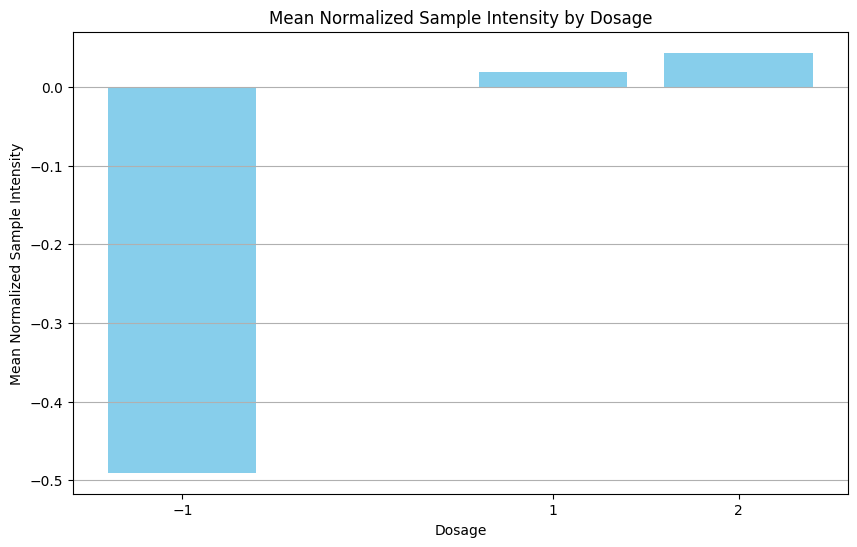

In [12]:
import matplotlib.pyplot as plt
grouped_df = joined_df.groupby('dosage')['normalized_sample_intensity'].mean().reset_index()

# Plotting the mean normalized_sample_intensity grouped by dosage
plt.figure(figsize=(10, 6))
plt.bar(grouped_df['dosage'], grouped_df['normalized_sample_intensity'], color='skyblue')
plt.xlabel('Dosage')
plt.ylabel('Mean Normalized Sample Intensity')
plt.title('Mean Normalized Sample Intensity by Dosage')
plt.xticks(grouped_df['dosage'])
plt.grid(axis='y')

# Display the plot
plt.show()